# tweet-sentiment-extraction: RoBERTa baseline

## Support

### Imports

In [1]:
import os
import sys
import time
import itertools
import functools

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 200)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler
plt.style.use('ggplot')
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['grid.color'] = 'grey'
mpl.rcParams['grid.linestyle'] = 'dashed'
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['patch.linewidth'] = 1
mpl.rcParams['patch.edgecolor'] = 'black'
mpl.rcParams['patch.force_edgecolor'] = True
mpl.rcParams['axes.prop_cycle'] = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c',
                                                '#d62728', '#9467bd', '#8c564b', 
                                                '#e377c2', '#7f7f7f', '#bcbd22', 
                                                '#17becf'])
%matplotlib inline

In [2]:
import torch
from torch import nn

### Constants

In [3]:
SEED = 42

### Functions

In [4]:
def df_merge_reduce(df_list, how='inner', keys=None):
    """Recursively merge list of pandas dataframes."""

    return functools.reduce(
        lambda df1, df2: pd.merge(
            left=df1,
            right=df2,
            how=how,
            on=keys,
            left_index=True if keys is None else False,
            right_index=True if keys is None else False
        ),
        df_list
    )

In [5]:
def df_summary(df, ps=np.arange(0.1,1,0.1)):
    """
    Enhance dataframe describe method output with additional statistics.
    """
    
    summary = df_merge_reduce([
        pd.DataFrame(df.dtypes, columns=['dtype']),
        pd.DataFrame(df.isna().sum(), columns=['nan_count']),
        pd.DataFrame(df.isna().sum()/
                     df.shape[0], columns=['nan_frac']),
        pd.DataFrame((df == 0).sum(), columns=['zero_count']),
        pd.DataFrame((df == 0).sum()/
                     df.shape[0], columns=['zero_frac']),
        pd.DataFrame(df.nunique(), columns=['nunique']),
        df.describe(include='all', percentiles=ps).T,
    ])
    
    return summary

### Random seed

In [6]:
import random

def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

In [7]:
seed_everything(SEED)

***

## Data

### Load data

In [8]:
DATA_DIR = './data'

In [9]:
converters={'text': lambda x: str(x), 'selected_text': lambda x: str(x)}
train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), converters=converters)
test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'), converters=converters)
sample_sub = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))

In [10]:
train = train[train.text != ''].reset_index(drop=True)
train.shape

(27480, 4)

In [11]:
test.shape

(3534, 3)

In [12]:
train.head().style

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative


### EDA

In [13]:
train.groupby('sentiment').agg(
    sent_count=('sentiment', 'count'),
    sent_frac=('sentiment', lambda x: np.around(x.shape[0] / train.shape[0], 2)),
)

,sent_count,sent_frac
sentiment,,
negative,7781,0.28
neutral,11117,0.40
positive,8582,0.31


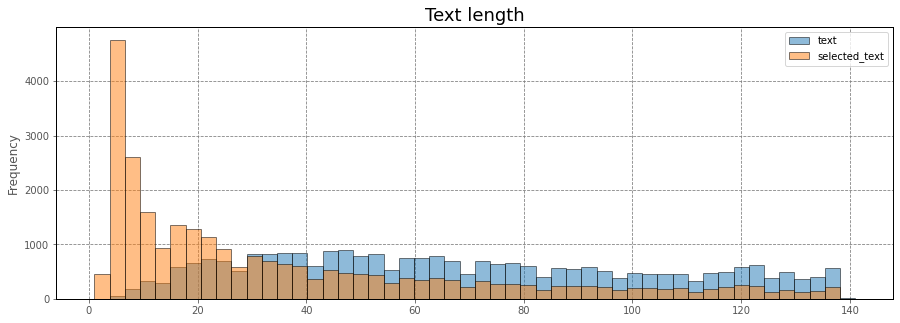

In [14]:
train[['text', 'selected_text']].applymap(len).plot(
    kind='hist', stacked=False, alpha=0.5, bins=50, figsize=(15, 5), title='Text length'
);

***

## Preprocessing

### RoBERTa

#### Load model and tokenizer

In [15]:
from transformers import RobertaModel, RobertaTokenizer, RobertaForQuestionAnswering, RobertaConfig
from tokenizers import ByteLevelBPETokenizer

In [16]:
MODEL_TYPE = 'roberta-base'
MODEL_PATH = './data/pretrained_roberta/'
TOKENIZER_PATH = './data/pretrained_roberta_tokenizer/'
VOCAB_PATH = './data/pretrained_roberta_tokenizer/vocab.json'
MERGES_PATH = './data/pretrained_roberta_tokenizer/merges.txt'

In [17]:
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(TOKENIZER_PATH, exist_ok=True)

In [18]:
# tokenizer = RobertaTokenizer.from_pretrained(MODEL_TYPE)

In [19]:
# roberta_config = RobertaConfig.from_pretrained(MODEL_TYPE, output_hidden_states=True)
# roberta = RobertaModel.from_pretrained(MODEL_TYPE, config=roberta_config)

In [20]:
# tokenizer.save_pretrained(TOKENIZER_PATH)
# roberta.save_pretrained(MODEL_PATH)

In [21]:
tokenizer = RobertaTokenizer.from_pretrained(TOKENIZER_PATH)
# tokenizer = ByteLevelBPETokenizer(
#     vocab_file=VOCAB_PATH, 
#     merges_file=MERGES_PATH, 
#     lowercase=True,
#     add_prefix_space=True
# )
roberta = RobertaModel.from_pretrained(MODEL_PATH)

#### Tokenizer demo

In [22]:
test_items = tokenizer.batch_encode_plus(train.text[:3], pad_to_max_length=True)
test_items

{'input_ids': [[0, 38, 12905, 417, 33, 2334, 6, 114, 38, 58, 164, 2, 1, 1, 1], [0, 407, 3036, 208, 2606, 38, 40, 2649, 47, 259, 11, 764, 3402, 16506, 2], [0, 127, 3504, 16, 11902, 162, 734, 2, 1, 1, 1, 1, 1, 1, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]]}

In [23]:
sents_w_space = list(map(lambda x: ' ' + x, train.sentiment.unique()))
sents_w_space

[' neutral', ' negative', ' positive']

In [24]:
SENT_IDS = [tokenizer.encode(s, add_special_tokens=False)[0] for s in sents_w_space]
SENT_IDS

[7974, 2430, 1313]

In [25]:
print(train.sentiment[100] + 
      2 * tokenizer.special_tokens_map['eos_token'] + 
      train.text[100])
print()
print(tokenizer.encode(train.sentiment[100] + 
                       2 * tokenizer.special_tokens_map['eos_token'] + 
                       train.text[100], do_lower_case=True, add_prefix_space=True))

positive</s></s>4am. And Im on the beach. Pretty

[0, 1313, 2, 2, 306, 424, 4, 178, 5902, 15, 5, 4105, 4, 20560, 2]


In [26]:
print(train.sentiment[100] + 
      2 * tokenizer.special_tokens_map['eos_token'] + 
      ' ' + ' '.join(train.text[100].lower().split()))
print()
print(tokenizer.encode(train.sentiment[100] + 
                       2 * tokenizer.special_tokens_map['eos_token'] + 
                       ' ' + ' '.join(train.text[100].lower().split()), add_prefix_space=True))

positive</s></s> 4am. and im on the beach. pretty

[0, 1313, 2, 2, 204, 424, 4, 8, 4356, 15, 5, 4105, 4, 1256, 2]


### Prepare text for tokenization

In [27]:
train['orig_text'] = train.text
train['orig_selected_text'] = train.selected_text
test['orig_text'] = test.text

In [28]:
def prep_text(row, tokenizer):
    return row.sentiment + \
        2 * tokenizer.special_tokens_map['eos_token'] + \
        ' ' + ' '.join(row.text.lower().split())

In [29]:
train['text'] = train.apply(lambda row: prep_text(row, tokenizer), axis=1)
test['text'] = test.apply(lambda row: prep_text(row, tokenizer), axis=1)

In [30]:
train['selected_text'] = train.apply(
    lambda row: ' ' + ' '.join(row.selected_text.lower().split()), axis=1
)

In [31]:
train.text.iloc[100], test.text.iloc[100]

('positive</s></s> 4am. and im on the beach. pretty',
 'neutral</s></s> oooh, sunshine! a patch of sunshine! and it will be gone by the time i leave work and replaced with rain. /vent')

In [32]:
print(list(train.text[:3]))
print(tokenizer.batch_encode_plus(list(train.text[:3]), pad_to_max_length=True))

['neutral</s></s> i`d have responded, if i were going', 'negative</s></s> sooo sad i will miss you here in san diego!!!', 'negative</s></s> my boss is bullying me...']
{'input_ids': [[0, 7974, 2, 2, 939, 12905, 417, 33, 2334, 6, 114, 939, 58, 164, 2, 1, 1, 1], [0, 2430, 2, 2, 98, 3036, 5074, 939, 40, 2649, 47, 259, 11, 15610, 1597, 2977, 16506, 2], [0, 2430, 2, 2, 127, 3504, 16, 11902, 162, 734, 2, 1, 1, 1, 1, 1, 1, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]]}


### Labels

In [33]:
def get_labels(enc_text, enc_sel_text, offset=0):
    start, end = None, None
    for i in range(len(enc_text) - len(enc_sel_text) + 1):
        if enc_text[i : i + len(enc_sel_text)] == enc_sel_text:
            start, end = i, i + len(enc_sel_text) - 1
    if start and end:
        return start + offset, end + offset

In [34]:
print(train.text[3])
print(train.selected_text[3])
print(tokenizer.encode(train.text[3], add_special_tokens=True))
print(tokenizer.encode(train.selected_text[3], add_special_tokens=False))

negative</s></s> what interview! leave me alone
 leave me alone
[0, 2430, 2, 2, 99, 1194, 328, 989, 162, 1937, 2]
[989, 162, 1937]


In [35]:
get_labels(tokenizer.encode(train.text[3]), 
           tokenizer.encode(train.selected_text[3], 
                            add_special_tokens=False))

(7, 9)

In [36]:
train['labels'] = train.apply(
    lambda row: get_labels(
        tokenizer.encode(row.text, add_special_tokens=True),
        tokenizer.encode(row.selected_text, add_special_tokens=False),
        offset=0
    ), 
    axis=1
)

In [37]:
train = train[~train.labels.isna()].reset_index(drop=True)
train.shape

(24886, 7)

In [38]:
train.iloc[1].text, train.iloc[1].selected_text, train.iloc[1].labels

('negative</s></s> sooo sad i will miss you here in san diego!!!',
 ' sooo sad',
 (4, 6))

In [39]:
idx = 20
train.iloc[idx].text, train.iloc[idx].selected_text, train.iloc[idx].labels

('positive</s></s> playing ghost online is really interesting. the new updates are kirin pet and metamorph for third job. can`t wait to have a dragon pet',
 ' interesting.',
 (9, 10))

### Dataset

#### Dataset class

In [40]:
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import Sampler

In [41]:
class TweetDataset(TorchDataset):
    def __init__(self, df):
        self.df = df
        self.return_labels = 'labels' in df.columns
        self.selected_text = 'selected_text' in df.columns
        
    def __getitem__(self, index):
        return {
            'orig_text': self.df.loc[index].orig_text,
            'orig_selected_text': self.df.loc[index].orig_selected_text if self.return_labels else '',
            'text': self.df.loc[index].text,
            'selected_text': self.df.loc[index].selected_text if self.return_labels else '',
            'sentiment': self.df.loc[index].sentiment,
            'labels': self.df.loc[index].labels if self.return_labels else (0, 0),
            'textID': self.df.loc[index].textID
        }
    
    def __len__(self):
        return len(self.df)

In [42]:
dataset = TweetDataset(train)

In [43]:
dataset[2]

{'orig_text': 'my boss is bullying me...',
 'orig_selected_text': 'bullying me',
 'text': 'negative</s></s> my boss is bullying me...',
 'selected_text': ' bullying me',
 'sentiment': 'negative',
 'labels': (7, 8),
 'textID': '088c60f138'}

#### Train/val split

In [44]:
VAL_SIZE = 0.1

In [45]:
val_length = int(len(dataset) * VAL_SIZE)

In [46]:
train_dataset, val_dataset = random_split(dataset, [len(dataset) - val_length, val_length])

In [47]:
len(train_dataset), len(val_dataset)

(22398, 2488)

#### DataLoaders

In [48]:
class PaddingEncoder():
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        
    def _encode_pad(self, items, return_tensors):
        return self.tokenizer.batch_encode_plus(
            items,
            add_special_tokens=True,
            pad_to_max_length=True,
            return_tensors=return_tensors
        )
        
    def __call__(self, item_list):
        batch = {}
        
        # Batch-encode list of texts
        text_encoding = self._encode_pad([item['text'] for item in item_list], 'pt')
        
        # Stack token ids, masks and labels into padded tensors
        batch['labels'] = torch.from_numpy(np.array([item['labels'] for item in item_list]))
        batch['text_ids'] = text_encoding['input_ids']
        batch['text_mask'] = text_encoding['attention_mask']
        
        # Process type ids (sentiment as sentence A, text as sentence B)
        type_ids = np.array(text_encoding['input_ids'])
        type_ids = np.where(type_ids > 0, 1, 0)
        type_ids[:, :3] = 0
        batch['type_ids'] = torch.from_numpy(type_ids)
        
        # Keep answer and textID unchanged
        batch['selected_text'] = [item['selected_text'] for item in item_list]
        batch['textID'] = [item['textID'] for item in item_list]
        
        return batch

In [49]:
BATCH_SIZE = 16

In [50]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=PaddingEncoder(tokenizer)
)

In [51]:
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=PaddingEncoder(tokenizer)
)

In [52]:
test_batch = next(iter(train_loader))
for k in test_batch.keys():
    if k not in ['selected_text', 'textID']:
        print(k, test_batch[k].shape)
    else:
        print(k, test_batch[k][:3], '...')

labels torch.Size([16, 2])
text_ids torch.Size([16, 35])
text_mask torch.Size([16, 35])
type_ids torch.Size([16, 35])
selected_text [' yay me', ' thank you for being such an awesome mother', ' thanks.'] ...
textID ['91f408f6f0', '9daf95b109', '1bcdbbef14'] ...


***

## Training

### Test RoBERTa output

In [53]:
test_batch['text_ids'].shape

torch.Size([16, 35])

In [54]:
test_roberta_out = roberta(
    input_ids=test_batch['text_ids'], 
    attention_mask=test_batch['text_mask']
)

In [55]:
len(test_roberta_out[2]), test_roberta_out[2][-1].shape

(13, torch.Size([16, 35, 768]))

### Model classes

In [56]:
roberta.config.hidden_size

768

In [57]:
class RobertaBase(nn.Module):
    def __init__(self, pretrained, drop=0.5):
        super().__init__()
        self.transformer = pretrained
        self.drop = nn.Dropout(p=drop)
        self.fc = nn.Linear(
            in_features=self.transformer.config.hidden_size,
            out_features=2
        )
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)
    
    def forward(self, batch):
        
        # Apply transformer to text
        _, _, trf_out = self.transformer(
            input_ids=batch['text_ids'], 
            attention_mask=batch['text_mask']
        )
        
        # Average 3 last layers of transformer
        embs = torch.stack([trf_out[-1], trf_out[-2], trf_out[-3]]).mean(0)
        fc_out = self.fc(self.drop(embs))
        fc_out_start, fc_out_end = fc_out.split(1, dim=-1)
            
        return fc_out_start.squeeze(-1), fc_out_end.squeeze(-1)

### Check model output

In [58]:
test_model = RobertaBase(
    pretrained=roberta,
    drop=0.5
)

In [59]:
for k in test_batch.keys():
    if k not in ['selected_text', 'textID']:
        print(k, test_batch[k].shape)

labels torch.Size([16, 2])
text_ids torch.Size([16, 35])
text_mask torch.Size([16, 35])
type_ids torch.Size([16, 35])


In [60]:
with torch.no_grad():
    model_out = test_model.forward(test_batch)

In [61]:
model_out[0].shape, model_out[1].shape

(torch.Size([16, 35]), torch.Size([16, 35]))

### Train/val support

In [62]:
def get_special_mask(batch_text_ids, special_ids):
    """Mask with 1 for positions of all special indices."""
    
    special_ids_mask = functools.reduce(
        lambda x, y: x + y,
        [batch_text_ids == sp_ind for sp_ind in special_ids]
    )
    
    return special_ids_mask

In [63]:
def mask_output(pred, batch_text_ids, special_ids):
    """Mask model output with -inf at special indices' positions."""
    
#     masking_value = torch.finfo(pred.dtype).min
    masking_value = float('-inf')
    
    return torch.where(
        get_special_mask(batch_text_ids, special_ids).to('cuda' if pred.is_cuda else 'cpu'),
        (torch.ones_like(pred) * masking_value).to('cuda' if pred.is_cuda else 'cpu'),
        pred
    )

In [64]:
mask_output(
    model_out[0], 
    test_batch['text_ids'], 
    tokenizer.all_special_ids + SENT_IDS
)

tensor([[       -inf,        -inf,        -inf,        -inf,  2.1684e-01,
          3.2490e-01, -1.3457e-01,  4.0788e-01, -7.6948e-01, -8.6780e-02,
          2.7615e-04, -1.3882e-02,  1.2381e-01,  4.9700e-01,  5.6912e-01,
          1.4781e-01,  2.3058e-01, -5.4517e-02,  3.0758e-01, -2.2114e-01,
          7.5724e-01,        -inf,        -inf,        -inf,        -inf,
                -inf,        -inf,        -inf,        -inf,        -inf,
                -inf,        -inf,        -inf,        -inf,        -inf],
        [       -inf,        -inf,        -inf,        -inf,  4.0974e-01,
          3.0437e-02,  3.4322e-01,  1.2353e+00, -8.2559e-02, -1.5857e-01,
          1.9674e-01, -9.7082e-02,  3.6498e-01, -6.8476e-03,  4.4771e-02,
          3.4542e-01, -5.2419e-01,  2.8988e-01, -6.0153e-02, -5.9003e-01,
          4.7431e-01,  3.5788e-01,        -inf,        -inf,        -inf,
                -inf,        -inf,        -inf,        -inf,        -inf,
                -inf,        -inf,   

In [65]:
torch.softmax(mask_output(
    model_out[0], 
    test_batch['text_ids'], 
    tokenizer.all_special_ids + SENT_IDS
), 1)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0604, 0.0673, 0.0425, 0.0731, 0.0225,
         0.0446, 0.0486, 0.0479, 0.0550, 0.0799, 0.0859, 0.0564, 0.0612, 0.0460,
         0.0661, 0.0390, 0.1037, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0665, 0.0455, 0.0623, 0.1519, 0.0407,
         0.0377, 0.0538, 0.0401, 0.0636, 0.0439, 0.0462, 0.0624, 0.0262, 0.0590,
         0.0416, 0.0245, 0.0710, 0.0632, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1833, 0.1546, 0.1441, 0.2541, 0.1255,
         0.1383, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1657, 

#### Train

In [66]:
def batch_to_device(batch, device):
    for k in batch:
        if isinstance(batch[k], torch.Tensor):
            batch[k] = batch[k].to(device, dtype=torch.long)
            
    return batch

In [67]:
def get_batch_loss(model, criterion, optimizer, batch, special_ids=None):
    out_start, out_end = model(batch)
    
    if special_ids:
        out_start = mask_output(out_start, batch['text_ids'], special_ids)
        out_end = mask_output(out_end, batch['text_ids'], special_ids)
        
    loss_start = criterion(out_start, batch['labels'][:, 0])
    loss_end = criterion(out_end, batch['labels'][:, 1])
    loss = loss_start + loss_end
    
    return loss

In [68]:
def train_on_batch(model, criterion, optimizer, batch, scheduler=None, special_ids=None):
    model.train()
    optimizer.zero_grad()
    loss = get_batch_loss(model, criterion, optimizer, batch, special_ids)
    loss.backward(torch.ones_like(loss))
    optimizer.step()
    if scheduler:
        scheduler.step()
    
    return loss

In [69]:
train_on_batch(
    test_model, 
    nn.CrossEntropyLoss(), 
    torch.optim.Adam(test_model.parameters()),
    test_batch,
    special_ids=tokenizer.all_special_ids + SENT_IDS
)

tensor(5.3022, grad_fn=<AddBackward0>)

#### Predict

In [70]:
def get_best_start_end(pred_start, pred_end):
    """Calculate start and end postions (s, e) such that:
        1) s <= e
        2) pred_start[s] * pred_start[e] => max
    """
    
    # Upper triangular ((i > j) == 0) matrix of prediction vectors' outer product
    dists = torch.matmul(
        pred_start.view(-1, 1), 
        pred_end.view(1, -1)
    ).triu()
    
    # Indices of maximum element in the outer product matrix
    best_inds = np.unravel_index(
        dists.to('cpu').detach().numpy().argmax(), 
        dists.shape
    )
    
    return best_inds

In [71]:
def predict_on_batch(model, batch, special_ids=None):
    model.eval()
    with torch.no_grad():
        out_start, out_end = model(batch)
        
        if special_ids:
            out_start = mask_output(out_start, batch['text_ids'], special_ids)
            out_end = mask_output(out_end, batch['text_ids'], special_ids)
        
        preds_start = torch.softmax(out_start, dim=1)
        preds_end = torch.softmax(out_end, dim=1)
        
        return [get_best_start_end(*pred) for pred in zip(preds_start, preds_end)]

In [72]:
test_pred = predict_on_batch(test_model, test_batch, tokenizer.all_special_ids + SENT_IDS)
test_pred

[(18, 20),
 (5, 13),
 (4, 9),
 (4, 7),
 (4, 13),
 (4, 25),
 (4, 14),
 (4, 11),
 (4, 29),
 (4, 12),
 (4, 33),
 (4, 28),
 (13, 25),
 (4, 5),
 (4, 12),
 (4, 11)]

In [73]:
test_batch

{'labels': tensor([[18, 20],
         [14, 21],
         [ 8,  9],
         [ 4,  7],
         [11, 13],
         [ 4, 25],
         [ 4, 14],
         [ 9,  9],
         [ 4, 29],
         [ 4, 27],
         [ 4, 33],
         [ 4, 28],
         [ 4, 25],
         [ 4,  4],
         [12, 13],
         [ 4, 11]]),
 'text_ids': tensor([[    0,  1313,     2,     2,   160,   173,    11,   457,    41,  1946,
              4,   562,    41,   475,  1069,    71,    14,     4,  1423,   857,
            162,     2,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1],
         [    0,  1313,     2,     2,  4832,  1372,   985, 12905,    29,   183,
              7,   127,   985,     4,  3392,    47,    13,   145,   215,    41,
           6344,   985,     2,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1],
         [    0,  1313,     2,     2,   181,  1193,   298,     4,  2446,     4,
              2,    

#### Validate

In [74]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    
    return float(len(c)) / (len(a) + len(b) - len(c))

In [75]:
def get_pred_text(pred, batch, tokenizer):
    return tokenizer.batch_decode(
            [batch['text_ids'][i][pred[i][0] : pred[i][1] + 1] 
             for i in range(len(pred))],
            skip_special_tokens=True,
            clean_up_tokenization_spaces=True
        )

In [76]:
def jaccard_on_batch(model, batch, tokenizer, special_ids=None):
    pred = predict_on_batch(model, batch, special_ids)
    true_answers = batch['selected_text']
    pred_answers = get_pred_text(pred, batch, tokenizer)
    jaccards = [
        jaccard(pred, true) 
        for (pred, true)
        in zip(pred_answers, true_answers)
    ]
        
    return np.mean(jaccards)

In [77]:
jaccard_on_batch(test_model, test_batch, tokenizer, tokenizer.all_special_ids + SENT_IDS)

0.6320022475393319

### Trainer class

In [78]:
def np_finite_mean(x):
    if not isinstance(x, np.ndarray):
        x = np.array(x)
    return np.mean(x[x != float('inf')])

In [79]:
class Trainer:
    def __init__(self, model, criterion, optimizer, tokenizer, scheduler=None, 
                 device='cuda', sent_ids=SENT_IDS):
        self.device = device
        self.model = model.to(self.device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.tokenizer = tokenizer
        self.scheduler = scheduler
        self.sent_ids = sent_ids
        self.train_losses = []
        self.train_jaccards = []
        self.val_losses = []
        self.val_jaccards = []
        self.epochs = 0
        
    def train_epoch(self, loader, rep_freq):
        print('.' * 50)
        
        batch_losses = []
        batch_jaccards = []
        running_loss = 0.0
        running_jaccard = 0.0
        self.epochs += 1
        
        for b_num, batch in enumerate(loader):
            batch_start = time.time()
            batch = batch_to_device(batch, self.device)
            
            mean_batch_loss = train_on_batch(
                model=self.model,
                criterion=self.criterion,
                optimizer=self.optimizer,
                batch=batch,
                scheduler=self.scheduler,
                special_ids=self.tokenizer.all_special_ids + self.sent_ids
            )
            
            mean_batch_jaccard = jaccard_on_batch(
                model=self.model,
                batch=batch,
                tokenizer=tokenizer,
                special_ids=self.tokenizer.all_special_ids + self.sent_ids
            )
            
            batch_losses.append(mean_batch_loss.to('cpu').detach().numpy())
            batch_jaccards.append(mean_batch_jaccard)
            
            running_loss += mean_batch_loss
            running_jaccard += mean_batch_jaccard

            if (b_num + 1) % rep_freq == 0:
                mask = 'Batch {} done in {:.0f} ms | running loss: {:.4f} | running jaccard: {:.4f}'
                print(
                    mask.format(
                        b_num + 1, 
                        (time.time() - batch_start) * 1000, 
                        running_loss / rep_freq,
                        running_jaccard / rep_freq,
                ))
                running_loss = 0
                running_jaccard = 0
                
        print('.' * 50 + '\n')
                
        return batch_losses, batch_jaccards
    
    def validate(self, loader):
        batch_losses = []
        batch_jaccards = []
        
        with torch.no_grad():
            for batch in iter(loader):
                batch = batch_to_device(batch, self.device)
                
                mean_batch_loss = get_batch_loss(
                    model=self.model,
                    criterion=self.criterion,
                    optimizer=self.optimizer,
                    batch=batch,
                    special_ids=self.tokenizer.all_special_ids + self.sent_ids
                )
                
                mean_batch_jaccard = jaccard_on_batch(
                    model=self.model,
                    batch=batch,
                    tokenizer=tokenizer,
                    special_ids=self.tokenizer.all_special_ids + self.sent_ids
                )

                batch_losses.append(mean_batch_loss.to('cpu').detach().numpy())
                batch_jaccards.append(mean_batch_jaccard)
                
        return batch_losses, batch_jaccards
        
    def train(self, num_epochs, train_loader, val_loader, rep_freq=20):
        time_start = time.time()
        for e_num in range(num_epochs):
            epoch_start = time.time()
            print('=' * 50 + '\n')
            print('Epoch {} of {} started\n'.format(e_num + 1, num_epochs))
            
            train_batch_losses, train_batch_jaccards = self.train_epoch(train_loader, rep_freq)
            self.train_losses.append(train_batch_losses)
            self.train_jaccards.append(train_batch_jaccards)
            
            print('Validating...\n')
            
            val_batch_losses, val_batch_jaccards = self.validate(val_loader)
            self.val_losses.append(val_batch_losses)
            self.val_jaccards.append(val_batch_jaccards)
            
            print('Epoch {} of {} finished in {:.0f} s'.format(
                e_num + 1, num_epochs, time.time() - epoch_start
            ))
            print('Mean epoch training loss: {:.4f}'.format(np_finite_mean(train_batch_losses)))
            print('Mean epoch validation loss: {:.4f}'.format(np_finite_mean(val_batch_losses)))
            print('Mean epoch training jaccard: {:.4f}'.format(np_finite_mean(train_batch_jaccards)))
            print('Mean epoch validation jaccard: {:.4f}\n'.format(np_finite_mean(val_batch_jaccards)))
            print('=' * 50 + '\n')
        print('Total elapsed time: {:.0f} s\n'.format(time.time() - time_start))
        print('=' * 50 + '\n')

***

## Experiments

In [80]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [81]:
NUM_EPOCHS = 4
REP_FREQ = 200

In [82]:
DROP = 0.5

In [83]:
model = RobertaBase(
    pretrained=roberta,
    drop=DROP
)

In [84]:
criterion = nn.CrossEntropyLoss(reduction='mean')

In [85]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 
     'weight_decay': 0.001},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]
optimizer = AdamW(optimizer_parameters, lr=3e-5)

In [86]:
scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=int(len(train_dataset) / BATCH_SIZE * NUM_EPOCHS)
)

In [87]:
trainer = Trainer(
    model=model, 
    criterion=criterion,
    optimizer=optimizer,
    tokenizer=tokenizer,
    scheduler=scheduler,
    device='cuda',
)

In [88]:
try:
    trainer.train(
        num_epochs=NUM_EPOCHS,
        train_loader=train_loader,
        val_loader=val_loader,
        rep_freq=REP_FREQ
    )
except KeyboardInterrupt:
    print('Traning interrupted')


Epoch 1 of 4 started

..................................................
Batch 200 done in 279 ms | running loss: 2.7517 | running jaccard: 0.6384
Batch 400 done in 257 ms | running loss: 1.8578 | running jaccard: 0.6976
Batch 600 done in 280 ms | running loss: 1.6878 | running jaccard: 0.7123
Batch 800 done in 257 ms | running loss: inf | running jaccard: 0.7358
Batch 1000 done in 249 ms | running loss: inf | running jaccard: 0.7271
Batch 1200 done in 244 ms | running loss: inf | running jaccard: 0.7419
Batch 1400 done in 243 ms | running loss: inf | running jaccard: 0.7260
..................................................

Validating...

Epoch 1 of 4 finished in 409 s
Mean epoch training loss: 1.7663
Mean epoch validation loss: 1.4456
Mean epoch training jaccard: 0.7113
Mean epoch validation jaccard: 0.7172



Epoch 2 of 4 started

..................................................
Batch 200 done in 230 ms | running loss: inf | running jaccard: 0.7581
Batch 400 done in 280 ms | run

In [89]:
train_losses = list(map(np_finite_mean, trainer.train_losses))
val_losses = list(map(np_finite_mean, trainer.val_losses))
train_jaccards = list(map(np_finite_mean, trainer.train_jaccards))
val_jaccards = list(map(np_finite_mean, trainer.val_jaccards))

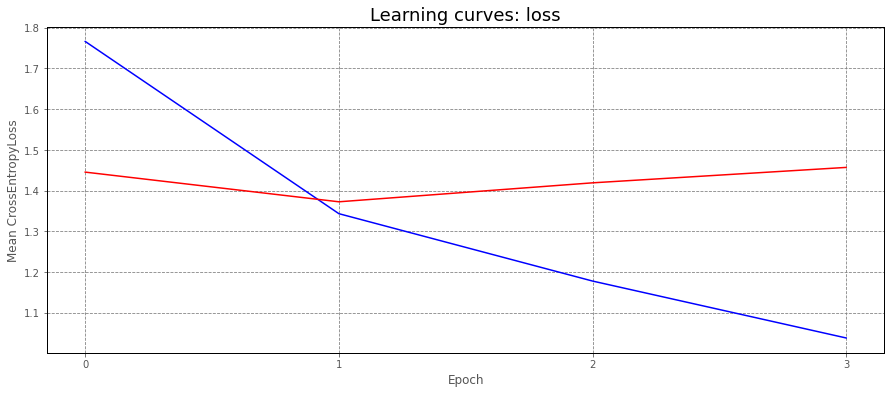

In [90]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(train_losses, c='blue', label='train loss')
ax.plot(val_losses, c='red', label='val loss')
ax.set_xticks(range(NUM_EPOCHS), minor=False)
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean CrossEntropyLoss')
ax.set_title('Learning curves: loss');

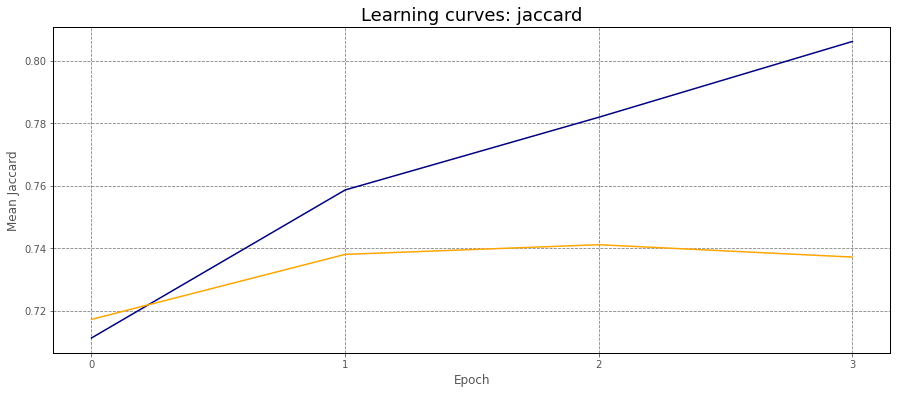

In [91]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(train_jaccards, c='navy', label='train jaccard')
ax.plot(val_jaccards, c='orange', label='val jaccard')
ax.set_xticks(range(NUM_EPOCHS), minor=False)
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Jaccard')
ax.set_title('Learning curves: jaccard');

## Save model

In [92]:
SAVE_MODEL_PATH = './data/baseline_roberta.pt'

In [93]:
# torch.save(model, SAVE_MODEL_PATH)

## Prediction

In [94]:
test_dataset = TweetDataset(test)

In [95]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=PaddingEncoder(tokenizer)
)

In [96]:
def get_sub_df(model, test_loader, tokenizer, sent_ids=SENT_IDS, device='cuda'):
    sub_df_parts = []
    
    for batch in iter(test_loader):
        batch = batch_to_device(batch, device)
        textID = batch['textID']
        pred = predict_on_batch(model, batch, tokenizer.all_special_ids + sent_ids)
        pred_text = get_pred_text(pred, batch, tokenizer)
        df_part = pd.DataFrame({
            'textID': textID,
            'selected_text': pred_text
        })
        sub_df_parts.append(df_part)
    
    return pd.concat(sub_df_parts)

In [97]:
sub_df = get_sub_df(model.to('cuda'), test_loader, tokenizer)

In [98]:
sub_df.head()

,textID,selected_text
0,f87dea47db,last session of the day
1,96d74cb729,exciting
2,eee518ae67,such a shame!
3,01082688c6,happy bday!
4,33987a8ee5,i like it!!


In [99]:
(sub_df.textID.values == test.textID.values).all()

True

In [1]:
# sub_df.to_csv('submission.csv')